In [1]:
import requests
import zipfile
import os
from tqdm.auto import tqdm

# --- 1. НАСТРОЙКИ ---


PUBLIC_LINK = "https://disk.yandex.ru/d/kz9g5msVqtahiw"  
ZIP_FILE_NAME = 'nutrition.zip'
DATA_DIR = './data'

# --- 2. ФУНКЦИЯ ДЛЯ ЗАГРУЗКИ ---

def download_file_from_yandex_disk(public_link, destination_path):
    """Загружает файл с Яндекс.Диска по публичной ссылке с progress bar."""
    
    # Получаем прямую ссылку для скачивания через API Яндекса
    api_url = f"https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={public_link}"
    
    try:
        response = requests.get(api_url)
        response.raise_for_status() # Проверяем, что запрос прошел успешно
        download_url = response.json()['href']
    except requests.RequestException as e:
        print(f"Ошибка получения ссылки для скачивания: {e}")
        return

    # Начинаем скачивание файла
    try:
        with requests.get(download_url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            
            with open(destination_path, 'wb') as f, tqdm(
                desc=destination_path,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
                for chunk in r.iter_content(chunk_size=8192):
                    size = f.write(chunk)
                    bar.update(size)
        print(f"Файл '{destination_path}' успешно загружен.")
        return True
    except requests.RequestException as e:
        print(f"Ошибка при скачивании файла: {e}")
        return False

# --- 3. ОСНОВНОЙ КОД ---

# Проверяем, существует ли уже папка с данными, чтобы не делать лишнюю работу
if os.path.exists(DATA_DIR) and os.path.exists(os.path.join(DATA_DIR, 'dish.csv')):
    print(f"Папка '{DATA_DIR}' уже существует и содержит данные. Пропускаем загрузку и распаковку.")
else:
    # Шаг 1: Загрузка архива
    print("Начинаю загрузку архива с Яндекс.Диска...")
    if download_file_from_yandex_disk(PUBLIC_LINK, ZIP_FILE_NAME):
        
        # Шаг 2: Создание папки для данных, если ее нет
        if not os.path.exists(DATA_DIR):
            os.makedirs(DATA_DIR)
            
        # Шаг 3: Распаковка архива
        print(f"\nНачинаю распаковку '{ZIP_FILE_NAME}' в папку '{DATA_DIR}'...")
        try:
            with zipfile.ZipFile(ZIP_FILE_NAME, 'r') as zip_ref:
                zip_ref.extractall(DATA_DIR)
            print("Архив успешно распакован.")
            
            # Шаг 4 (опционально): Удаление zip-архива после распаковки для экономии места
            os.remove(ZIP_FILE_NAME)
            print(f"Файл '{ZIP_FILE_NAME}' удален.")
            
        except zipfile.BadZipFile:
            print(f"Ошибка: файл '{ZIP_FILE_NAME}' не является корректным zip-архивом.")
            
    print("\nПодготовка данных завершена!")

Начинаю загрузку архива с Яндекс.Диска...


/home/ubuntu/food_calories/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
nutrition.zip: 100%|██████████| 1.33G/1.33G [00:15<00:00, 89.9MiB/s]


Файл 'nutrition.zip' успешно загружен.

Начинаю распаковку 'nutrition.zip' в папку './data'...
Архив успешно распакован.
Файл 'nutrition.zip' удален.

Подготовка данных завершена!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random

DATA_DIR = './data'

In [3]:
# --- 1. Загрузка CSV файлов ---
path_dish = os.path.join(DATA_DIR, 'dish.csv')
path_ingredients = os.path.join(DATA_DIR, 'ingredients.csv')

df_dish = pd.read_csv(path_dish)
df_ingredients = pd.read_csv(path_ingredients)

print("--- Таблица с блюдами (dish.csv) ---")
df_dish.info()
print(df_dish.head())

print("\n--- Таблица с ингредиентами (ingredients.csv) ---")
df_ingredients.info()
print(df_ingredients.head())

--- Таблица с блюдами (dish.csv) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3262 non-null   object 
 1   total_calories  3262 non-null   float64
 2   total_mass      3262 non-null   float64
 3   ingredients     3262 non-null   object 
 4   split           3262 non-null   object 
dtypes: float64(2), object(3)
memory usage: 127.5+ KB
           dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2

count    3262.000000
mean      255.012738
std       219.637570
min         0.000000
25%        80.114996
50%       209.110062
75%       375.122963
max      3943.325195
Name: total_calories, dtype: float64


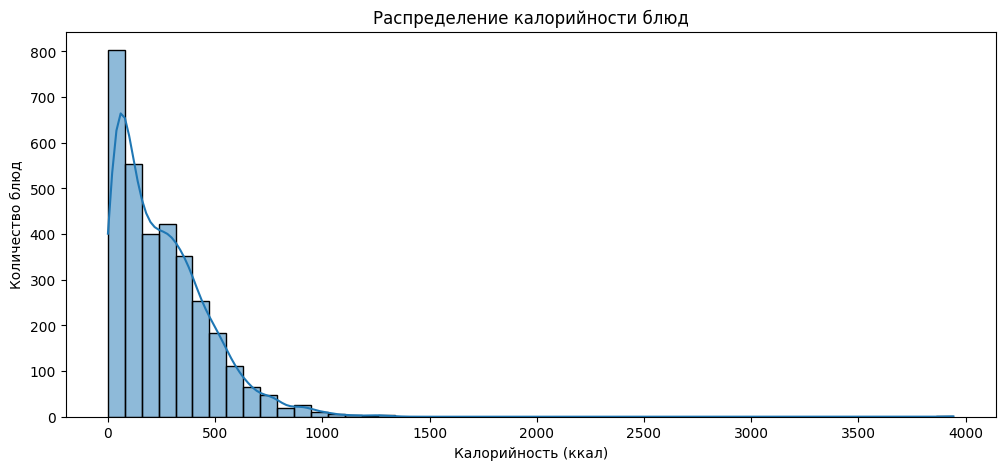

In [4]:
# --- 2. Анализ целевой переменной `total_calories` ---
print(df_dish['total_calories'].describe())

plt.figure(figsize=(12, 5))
sns.histplot(df_dish['total_calories'], bins=50, kde=True)
plt.title('Распределение калорийности блюд')
plt.xlabel('Калорийность (ккал)')
plt.ylabel('Количество блюд')
plt.show()

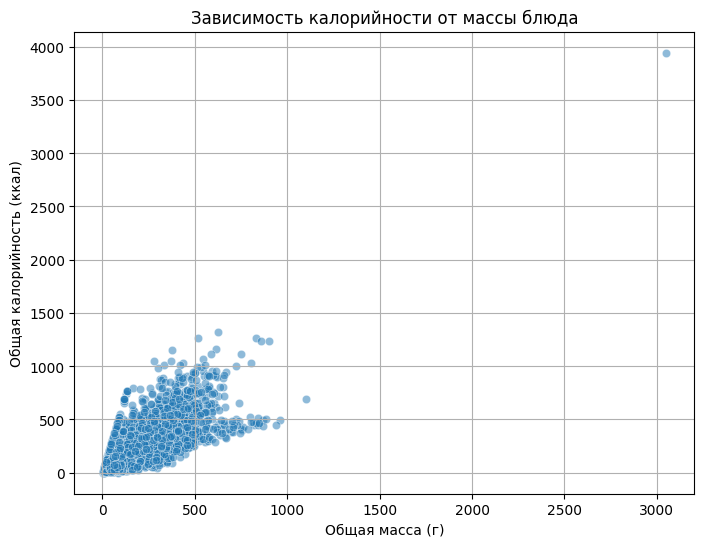

Коэффициент корреляции между массой и калорийностью: 0.76


In [5]:
# --- 3. Анализ связи между массой и калорийностью ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_dish, x='total_mass', y='total_calories', alpha=0.5)
plt.title('Зависимость калорийности от массы блюда')
plt.xlabel('Общая масса (г)')
plt.ylabel('Общая калорийность (ккал)')
plt.grid(True)
plt.show()

correlation = df_dish['total_mass'].corr(df_dish['total_calories'])
print(f"Коэффициент корреляции между массой и калорийностью: {correlation:.2f}")



count    3262.000000
mean        7.313305
std         6.943276
min         1.000000
25%         1.000000
50%         4.000000
75%        12.000000
max        34.000000
Name: ingredient_count, dtype: float64


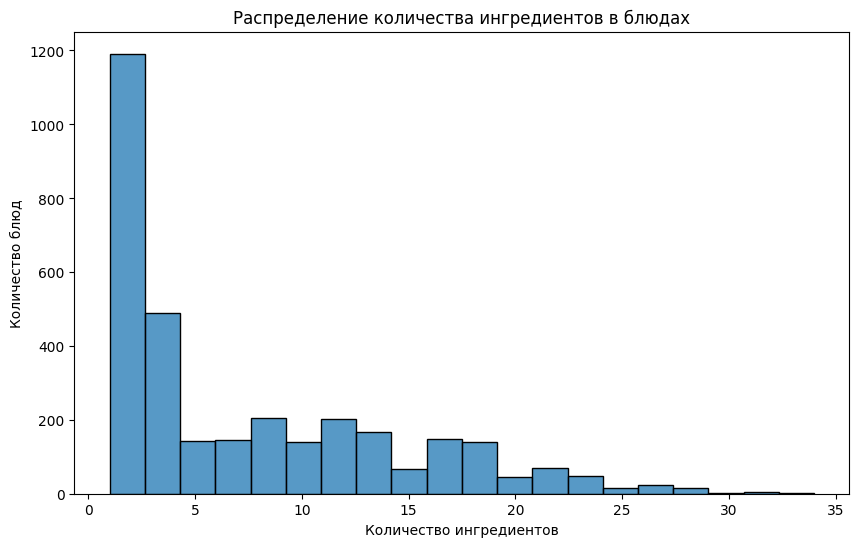

In [6]:
# --- 4. Анализ количества ингредиентов ---
df_dish['ingredient_count'] = df_dish['ingredients'].apply(lambda s: len(s.split(';')))

print(df_dish['ingredient_count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_dish['ingredient_count'], bins=20, kde=False)
plt.title('Распределение количества ингредиентов в блюдах')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Количество блюд')
plt.show()

--- 5 случайных изображений из датасета ---


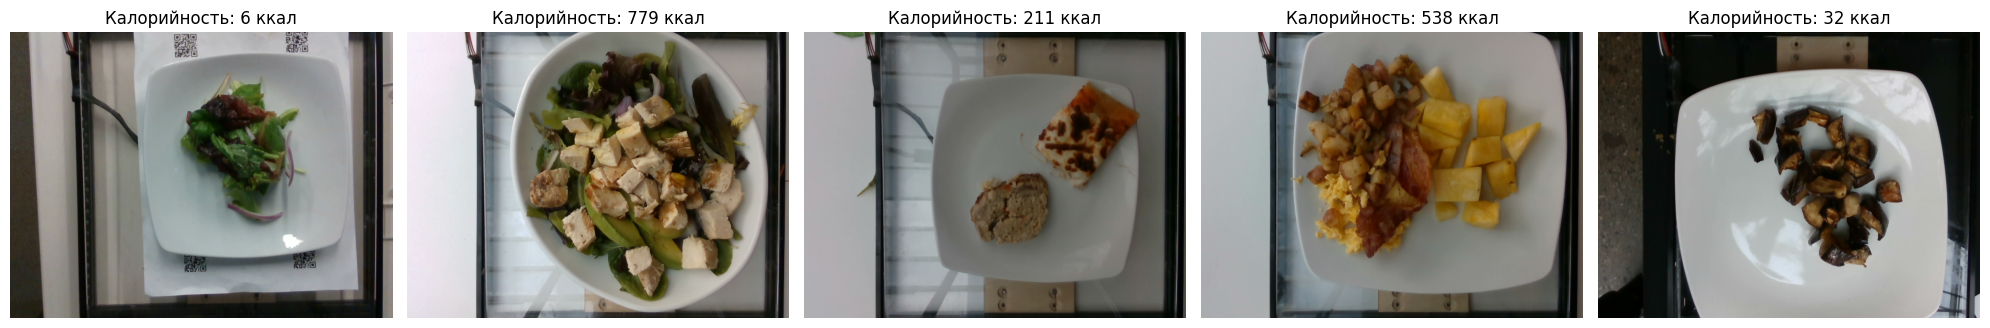

In [7]:
# --- 5. Визуальный анализ изображений ---
print("--- 5 случайных изображений из датасета ---")

images_dir = os.path.join(DATA_DIR, 'images')
all_dish_ids = df_dish['dish_id'].tolist()
random_dish_ids = random.sample(all_dish_ids, 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, dish_id in enumerate(random_dish_ids):
    image_path = os.path.join(images_dir, dish_id, 'rgb.png')
    
    try:
        img = Image.open(image_path)
        calories = df_dish[df_dish['dish_id'] == dish_id].iloc[0]['total_calories']
        
        axes[i].imshow(img)
        axes[i].set_title(f"Калорийность: {calories:.0f} ккал")
        axes[i].axis('off')

    except FileNotFoundError:
        axes[i].set_title(f"Изображение\nне найдено")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [8]:
# --- ЭТАП 3: ОБУЧЕНИЕ МОДЕЛИ ---

import config

from scripts.utils import train_model

print("--- НАСТРОЙКИ ОБУЧЕНИЯ ---")
print(f"Устройство: {config.DEVICE}")
print(f"Количество эпох: {config.EPOCHS}")
print(f"Размер батча: {config.BATCH_SIZE}")
print(f"Путь для сохранения модели: {config.MODEL_SAVE_PATH}")
print("--------------------------\n")


train_model(config)

--- НАСТРОЙКИ ОБУЧЕНИЯ ---
Устройство: cuda
Количество эпох: 25
Размер батча: 32
Путь для сохранения модели: ./best_model_efficientnet_finetuned.pth
--------------------------

Обучение будет на устройстве: cuda


/home/ubuntu/food_calories/scripts/dataset.py:26: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=int(0.1 * input_size[0]), max_width=int(0.1 * input_size[1]), p=0.5),



--- Эпоха 1 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


Средняя MAE на обучении: 117.44


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.27it/s]


MAE на тесте: 92.44
✨ Новая лучшая модель сохранена! MAE = 92.44

--- Эпоха 2 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.11it/s]


Средняя MAE на обучении: 86.57


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.24it/s]


MAE на тесте: 73.36
✨ Новая лучшая модель сохранена! MAE = 73.36

--- Эпоха 3 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.11it/s]


Средняя MAE на обучении: 76.78


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.48it/s]


MAE на тесте: 61.35
✨ Новая лучшая модель сохранена! MAE = 61.35

--- Эпоха 4 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.07it/s]


Средняя MAE на обучении: 73.11


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.49it/s]


MAE на тесте: 67.18

--- Эпоха 5 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.11it/s]


Средняя MAE на обучении: 69.94


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.25it/s]


MAE на тесте: 72.34

--- Эпоха 6 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.07it/s]


Средняя MAE на обучении: 68.25


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]


MAE на тесте: 74.44

--- Эпоха 7 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.10it/s]


Средняя MAE на обучении: 65.26


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]


MAE на тесте: 63.23

--- Эпоха 8 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.04it/s]


Средняя MAE на обучении: 62.30


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.25it/s]


MAE на тесте: 60.79
✨ Новая лучшая модель сохранена! MAE = 60.79

--- Эпоха 9 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.02it/s]


Средняя MAE на обучении: 57.99


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.48it/s]


MAE на тесте: 58.71
✨ Новая лучшая модель сохранена! MAE = 58.71

--- Эпоха 10 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.02it/s]


Средняя MAE на обучении: 58.99


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]


MAE на тесте: 59.58

--- Эпоха 11 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.97it/s]


Средняя MAE на обучении: 58.01


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.31it/s]


MAE на тесте: 62.30

--- Эпоха 12 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.02it/s]


Средняя MAE на обучении: 58.24


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


MAE на тесте: 59.01

--- Эпоха 13 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.05it/s]


Средняя MAE на обучении: 58.75


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.23it/s]


MAE на тесте: 58.13
✨ Новая лучшая модель сохранена! MAE = 58.13

--- Эпоха 14 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.98it/s]


Средняя MAE на обучении: 58.90


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]


MAE на тесте: 62.50

--- Эпоха 15 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.92it/s]


Средняя MAE на обучении: 57.78


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]


MAE на тесте: 56.63
✨ Новая лучшая модель сохранена! MAE = 56.63

--- Эпоха 16 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.05it/s]


Средняя MAE на обучении: 56.77


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.33it/s]


MAE на тесте: 61.98

--- Эпоха 17 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.02it/s]


Средняя MAE на обучении: 56.26


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.26it/s]


MAE на тесте: 59.74

--- Эпоха 18 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.01it/s]


Средняя MAE на обучении: 57.55


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.27it/s]


MAE на тесте: 58.70

--- Эпоха 19 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.02it/s]


Средняя MAE на обучении: 55.64


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]


MAE на тесте: 62.42

--- Эпоха 20 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.06it/s]


Средняя MAE на обучении: 58.00


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]


MAE на тесте: 58.89

--- Эпоха 21 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.03it/s]


Средняя MAE на обучении: 55.60


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]


MAE на тесте: 62.80

--- Эпоха 22 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.98it/s]


Средняя MAE на обучении: 55.97


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.27it/s]


MAE на тесте: 65.64

--- Эпоха 23 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.00it/s]


Средняя MAE на обучении: 53.64


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.48it/s]


MAE на тесте: 62.11

--- Эпоха 24 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.05it/s]


Средняя MAE на обучении: 56.75


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.49it/s]


MAE на тесте: 58.93

--- Эпоха 25 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.02it/s]


Средняя MAE на обучении: 56.48


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

MAE на тесте: 60.97

Обучение завершено!
Лучший результат MAE на тесте: 56.63


In [ ]:
# --- ФИНАЛЬНЫЙ ЭТАП: ДООБУЧЕНИЕ С ПОНИЖЕННОЙ СКОРОСТЬЮ ---

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Импортируем все необходимое
import config
from scripts.dataset import FoodDataset, collate_fn
from scripts.model import CaloriePredictor
from scripts.utils import set_seed

print("--- НАЧИНАЕМ ФИНАЛЬНОЕ ДООБУЧЕНИЕ ---")
set_seed(config.SEED)

# --- 1. Загружаем данные (как и раньше) ---
train_dataset = FoodDataset(config, split='train')
test_dataset = FoodDataset(config, split='test')
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)

# --- 2. Загружаем нашу ЛУЧШУЮ модель ---
model = CaloriePredictor(config, num_ingredients=train_dataset.num_ingredients).to(config.DEVICE)
# Загружаем веса из файла, который сохранила предыдущая ячейка
model.load_state_dict(torch.load(config.MODEL_SAVE_PATH))
print(f"Лучшая модель загружена из: {config.MODEL_SAVE_PATH}")

# --- 3. Создаем новый оптимизатор с ОЧЕНЬ НИЗКОЙ скоростью обучения ---
# Мы будем обновлять все веса, которые обучались до этого
all_trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(all_trainable_params, lr=config.IMAGE_LR / 10) # Делаем LR в 10 раз меньше, чем был у fine-tuning'а
loss_fn = nn.MSELoss()

# --- 4. Запускаем дообучение на несколько эпох ---
best_mae = 56.63 # Начинаем с нашего текущего лучшего результата
epochs_to_fine_tune = 10

for epoch in range(epochs_to_fine_tune):
    print(f"\n--- Эпоха дообучения {epoch + 1} / {epochs_to_fine_tune} ---")
    
    # Код обучения и валидации остается абсолютно таким же
    model.train()
    train_mae = 0
    for batch in tqdm(train_loader, desc="Дообучение"):
        images, ingredients, mass, calories = (batch['image'].to(config.DEVICE), batch['ingredients'].to(config.DEVICE), batch['mass'].to(config.DEVICE), batch['calories'].to(config.DEVICE))
        predictions = model(images, ingredients, mass)
        loss = loss_fn(predictions, calories)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_mae += torch.abs(predictions - calories).mean().item()
        
    print(f"Средняя MAE на дообучении: {train_mae / len(train_loader):.2f}")

    model.eval()
    val_mae = 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Оценка"):
            images, ingredients, mass, calories = (batch['image'].to(config.DEVICE), batch['ingredients'].to(config.DEVICE), batch['mass'].to(config.DEVICE), batch['calories'].to(config.DEVICE))
            predictions = model(images, ingredients, mass)
            val_mae += torch.abs(predictions - calories).mean().item()
    
    current_mae = val_mae / len(test_loader)
    print(f"MAE на тесте: {current_mae:.2f}")

    if current_mae < best_mae:
        best_mae = current_mae
        # Перезаписываем файл с моделью, если нашли решение еще лучше
        torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
        print(f"  Новая лучшая модель сохранена! MAE = {best_mae:.2f}")

print("\nФинальное дообучение завершено!")
print(f" Итоговый лучший результат MAE на тесте: {best_mae:.2f} ")